# Example of confidence interval computation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import zfit
from zfit.loss import ExtendedUnbinnedNLL
from zfit.minimize import Minuit

from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import ConfidenceInterval
from hepstats.hypotests.parameters import POIarray

from utils import one_minus_cl_plot, pltdist

/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit-0.4.2.dev40+g1d92060.d20200131-py3.7.egg/zfit/__init__.py:32: UserWarning: zfit has moved from TensorFlow 1.x to 2.x, which has some profound implications behind the scenes of zfit
    and minor ones on the user side. Be sure to read the upgrade guide (can be found in the README at the top)
     to have a seemless transition. If this is currently not doable (upgrading is highly recommended though)
     you can downgrade zfit to <0.4. Feel free to contact us in case of problems in order to fix them ASAP.
  you can downgrade zfit to <0.4. Feel free to contact us in case of problems in order to fix them ASAP.""")
/Users/matthieumarinangeli/anaconda3/envs/tfn2/lib/python3.7/site-packages/zfit-0.4.2.dev40+g1d92060.d20200131-py3.7.egg/zfit/util/execution.py:62: UserWarning: Not running on Linux. Determining available cpus for thread can failand be overestimated. Workaround (only if too many cpus are used):`zfit.r

In [2]:
plt.rcParams['figure.figsize'] = (9,8)
plt.rcParams['font.size'] = 16

### Fit of a Gaussian signal over an exponential background:

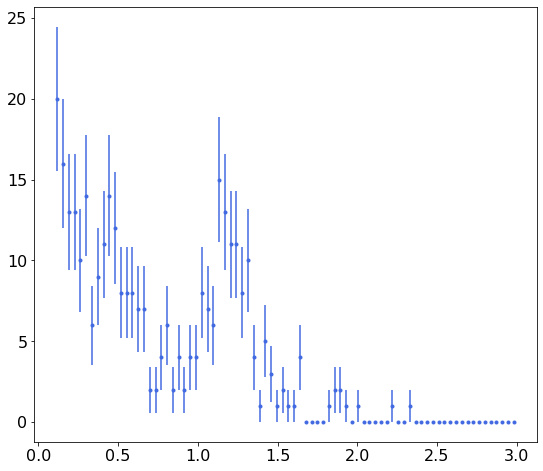

In [3]:
bounds = (0.1, 3.0)

# Data and signal

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 80)
data = np.concatenate((data,peak))
data = data[(data > bounds[0]) & (data < bounds[1])]

pltdist(data, bins=80, bounds=bounds)

In [4]:
obs = zfit.Space('x', limits=bounds)

In [5]:
mean = zfit.Parameter("mean", 1.2, 0.5, 2.0)
sigma = zfit.Parameter("sigma", 0.1, 0.02, 0.2)
lambda_ = zfit.Parameter("lambda",-2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 20., -20., len(data))
Nbkg = zfit.Parameter("Nbkg", len(data), 0., len(data)*1.1)

In [6]:
signal = Nsig * zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
background =  Nbkg * zfit.pdf.Exponential(obs=obs, lambda_=lambda_)
tot_model = signal + background

In [7]:
# Create the negative log likelihood
data_ = zfit.data.Data.from_numpy(obs=obs, array=data)
nll = ExtendedUnbinnedNLL(model=tot_model, data=data_) 

In [8]:
# Instantiate a minuit minimizer
minimizer = Minuit()

In [9]:
# minimisation of the loss function
minimum = minimizer.minimize(loss=nll)

------------------------------------------------------------------
| FCN = -1431                   |     Ncalls=146 (146 total)     |
| EDM = 0.000299 (Goal: 5E-05)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


NameError: name 'plotfitresult' is not defined

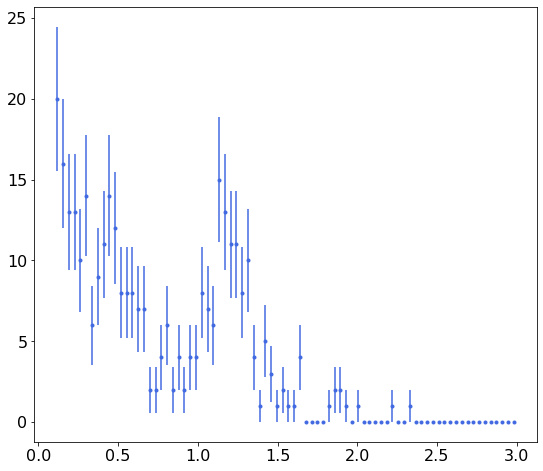

In [10]:
nbins = 80
pltdist(data, nbins, bounds)
plotfitresult(tot_model, bounds, nbins)
plt.xlabel("m [GeV/c$^2$]")
plt.ylabel("number of events")

### Confidence interval

We want to compute the confidence interval of the mean of the Gaussian at 68% confidence level.

In [ ]:
# instantation of the calculator
calculator = AsymptoticCalculator(nll, minimizer)
calculator.bestfit = minimum #optionnal

In [ ]:
# parameter of interest of the null hypothesis
poinull = POIarray(mean, np.linspace(1.15, 1.26, 100))

In [ ]:
# instantation of the discovery test
ci = ConfidenceInterval(calculator, poinull)

In [ ]:
ci.interval();

In [ ]:
f = plt.figure(figsize=(9, 8))
one_minus_cl_plot(poinull.values, ci.pvalues())
plt.xlabel("mean")
f.savefig("asy_ci.png")